## 0.5V

RL = 1kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.008084502), (-9.99, -0.008083524), (-9.98, -0.008082546)]
RL = 2kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.004256858), (-9.99, -0.004256296), (-9.98, -0.004255735)]
RL = 5kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.001769442), (-9.99, -0.00176912), (-9.98, -0.0017688)]
RL = 10kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.0009074329), (-9.99, -0.0009067921), (-9.98, -0.0009062119)]


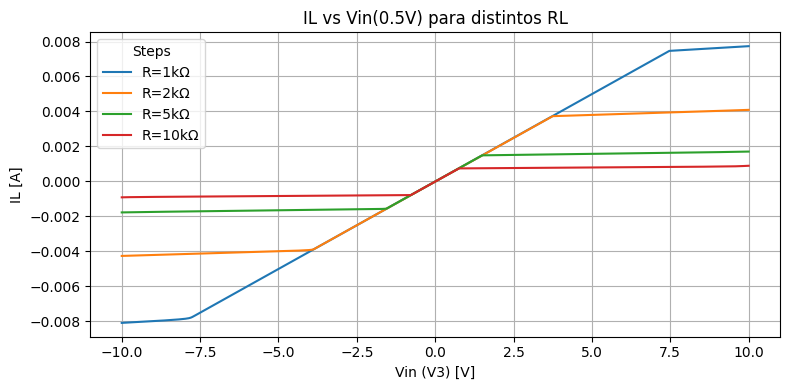

In [19]:
# --- IL vs v3 (LTspice .dc V3 ... con .step RL) ---
FILE_PATH = "IL_Vin_05.txt"   # <-- tu archivo exportado
FLIP_IL_SIGN = True

import re, math
import matplotlib.pyplot as plt

# Conversión de sufijos
SI = {"k":1e3,"K":1e3,"m":1e-3,"u":1e-6,"µ":1e-6,"n":1e-9,"p":1e-12}

def parse_num_with_suffix(s):
    m = re.match(r'\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*([kKmMuUµnNpP]?)', s)
    if not m:
        return float(s)
    return float(m.group(1)) * SI.get(m.group(2), 1.0)

def fmt_rl(rl):
    return f"{rl/1e3:.0f}kΩ" if rl>=1e3 else (f"{rl:.0f}Ω" if rl>=1 else f"{rl:g}Ω")

blocks = []
cur = None
col_idx = None  # dict con índices: {"v3":i, "il":j}

with open(FILE_PATH, "r") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # Cabecera de columnas: detectamos índices
        if line.lower().startswith(("v3","v(vin)","v(vout)","i(rl)")) and "step information" not in line.lower():
            headers = line.split()
            # mapa nombre -> índice
            name_to_idx = {h.lower(): i for i, h in enumerate(headers)}
            # buscamos índices relevantes
            i_v3 = name_to_idx.get("v3", 0)
            i_il = name_to_idx.get("i(rl)")
            if i_il is None:
                raise RuntimeError("No encontré la columna I(RL) en el archivo.")
            col_idx = {"v3": i_v3, "il": i_il}
            continue

        # Comienzo de un nuevo step
        if line.lower().startswith("step information:"):
            if cur and cur["x"]:
                blocks.append(cur)
            info = line.split(":",1)[1]
            m_rl = re.search(r'rl\s*=\s*([^\s,]+)', info, flags=re.I)
            RL = parse_num_with_suffix(m_rl.group(1)) if m_rl else math.nan
            cur = {"RL": RL, "x": [], "y": []}
            continue

        # Filas numéricas
        parts = line.split()
        if col_idx and len(parts) > max(col_idx.values()):
            try:
                x = float(parts[col_idx["v3"]])   # <<< eje X = V3 (la barrida)
                y = float(parts[col_idx["il"]])   # I(RL)
                if FLIP_IL_SIGN:
                    y = -y
                cur["x"].append(x)
                cur["y"].append(y)
            except ValueError:
                pass

# Agregar último bloque
if cur and cur["x"]:
    blocks.append(cur)

# Debug rápido: mostrar 3 puntos por step
for b in blocks:
    print(f"RL = {fmt_rl(b['RL'])}  ->  primeros puntos (v3, IL): {list(zip(b['x'][:3], b['y'][:3]))}")

# Plot
plt.figure(figsize=(8,4))
for b in blocks:
    plt.plot(b["x"], b["y"], label=f"R={fmt_rl(b['RL'])}")
plt.xlabel("Vin (V3) [V]")
plt.ylabel("IL [A]")
plt.title("IL vs Vin(0.5V) para distintos RL")
plt.grid(True)
plt.legend(title="Steps")
plt.tight_layout()
plt.show()

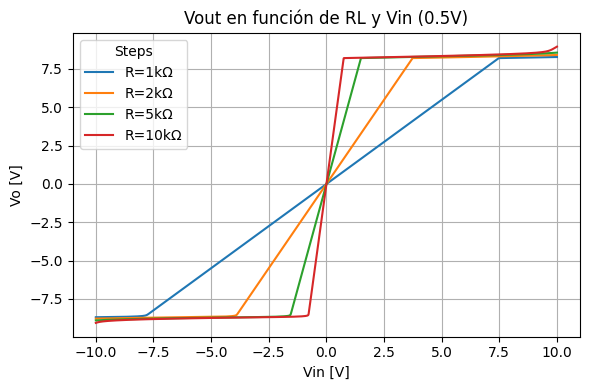

In [20]:
import re, math
import matplotlib.pyplot as plt

FILE_PATH = "Vout_Vin_05.txt"   # <-- nombre de tu archivo

# Conversión de sufijos (k, m, µ, etc.)
SI = {"k":1e3,"K":1e3,"m":1e-3,"u":1e-6,"µ":1e-6,"n":1e-9,"p":1e-12}
def parse_num(s):
    m = re.match(r'\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*([kKmMuUµnNpP]?)', s)
    return float(m.group(1)) * SI.get(m.group(2), 1.0) if m else float(s)

def fmt_rl(rl):
    return f"{rl/1e3:.0f}kΩ" if rl >= 1e3 else f"{rl:.0f}Ω"

blocks = []
cur = None
col_idx = None  # índices de columnas: {"vin": i, "vout": j}

with open(FILE_PATH, "r") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # Cabecera de columnas -> detectamos índices
        if line.lower().startswith("v3") or line.lower().startswith("v(v3)") \
           or (("v(vout)" in line.lower()) and ("step information" not in line.lower())):
            headers = line.split()
            name_to_i = {h.lower(): i for i, h in enumerate(headers)}
            # buscamos Vin (v3) y Vout
            i_vin  = name_to_i.get("v3", name_to_i.get("v(v3)", 0))
            i_vout = name_to_i.get("v(vout)")
            if i_vout is None:
                raise RuntimeError("No encontré columna V(vout) en el archivo.")
            col_idx = {"vin": i_vin, "vout": i_vout}
            continue

        # Nuevo step
        if line.lower().startswith("step information:"):
            if cur and cur["x"]:
                blocks.append(cur)
            info = line.split(":", 1)[1]
            m_rl = re.search(r'rl\s*=\s*([^\s,]+)', info, flags=re.I)
            RL = parse_num(m_rl.group(1)) if m_rl else math.nan
            cur = {"RL": RL, "x": [], "y": []}
            continue

        # Filas numéricas
        parts = line.split()
        if col_idx and len(parts) > max(col_idx.values()):
            try:
                vin  = float(parts[col_idx["vin"]])
                vout = float(parts[col_idx["vout"]])
                cur["x"].append(vin)
                cur["y"].append(vout)
            except ValueError:
                pass

# último bloque
if cur and cur["x"]:
    blocks.append(cur)

# --- Gráfico ---
plt.figure(figsize=(6,4))
for b in blocks:
    plt.plot(b["x"], b["y"], label=f"R={fmt_rl(b['RL'])}")

plt.xlabel("Vin [V]")
plt.ylabel("Vo [V]")
plt.title("Vout en función de RL y Vin (0.5V)")
plt.grid(True)
plt.legend(title="Steps")
plt.tight_layout()
plt.show()


## 1V

RL = 1kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.008084502), (-9.99, -0.008083524), (-9.98, -0.008082546)]
RL = 2kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.004256858), (-9.99, -0.004256296), (-9.98, -0.004255735)]
RL = 5kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.001769442), (-9.99, -0.00176912), (-9.98, -0.0017688)]
RL = 10kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.0009074329), (-9.99, -0.0009067921), (-9.98, -0.0009062119)]


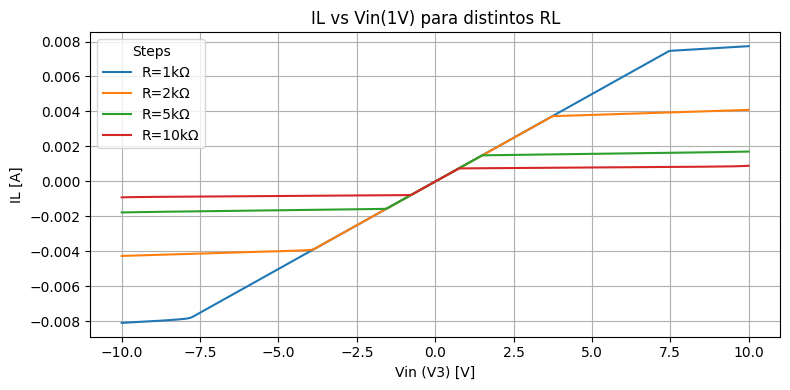

In [21]:
# --- IL vs v3 (LTspice .dc V3 ... con .step RL) ---
FILE_PATH = "IL_Vin_1.txt"   # <-- tu archivo exportado
FLIP_IL_SIGN = True

import re, math
import matplotlib.pyplot as plt

# Conversión de sufijos
SI = {"k":1e3,"K":1e3,"m":1e-3,"u":1e-6,"µ":1e-6,"n":1e-9,"p":1e-12}

def parse_num_with_suffix(s):
    m = re.match(r'\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*([kKmMuUµnNpP]?)', s)
    if not m:
        return float(s)
    return float(m.group(1)) * SI.get(m.group(2), 1.0)

def fmt_rl(rl):
    return f"{rl/1e3:.0f}kΩ" if rl>=1e3 else (f"{rl:.0f}Ω" if rl>=1 else f"{rl:g}Ω")

blocks = []
cur = None
col_idx = None  # dict con índices: {"v3":i, "il":j}

with open(FILE_PATH, "r") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # Cabecera de columnas: detectamos índices
        if line.lower().startswith(("v3","v(vin)","v(vout)","i(rl)")) and "step information" not in line.lower():
            headers = line.split()
            # mapa nombre -> índice
            name_to_idx = {h.lower(): i for i, h in enumerate(headers)}
            # buscamos índices relevantes
            i_v3 = name_to_idx.get("v3", 0)
            i_il = name_to_idx.get("i(rl)")
            if i_il is None:
                raise RuntimeError("No encontré la columna I(RL) en el archivo.")
            col_idx = {"v3": i_v3, "il": i_il}
            continue

        # Comienzo de un nuevo step
        if line.lower().startswith("step information:"):
            if cur and cur["x"]:
                blocks.append(cur)
            info = line.split(":",1)[1]
            m_rl = re.search(r'rl\s*=\s*([^\s,]+)', info, flags=re.I)
            RL = parse_num_with_suffix(m_rl.group(1)) if m_rl else math.nan
            cur = {"RL": RL, "x": [], "y": []}
            continue

        # Filas numéricas
        parts = line.split()
        if col_idx and len(parts) > max(col_idx.values()):
            try:
                x = float(parts[col_idx["v3"]])   # <<< eje X = V3 (la barrida)
                y = float(parts[col_idx["il"]])   # I(RL)
                if FLIP_IL_SIGN:
                    y = -y
                cur["x"].append(x)
                cur["y"].append(y)
            except ValueError:
                pass

# Agregar último bloque
if cur and cur["x"]:
    blocks.append(cur)

# Debug rápido: mostrar 3 puntos por step
for b in blocks:
    print(f"RL = {fmt_rl(b['RL'])}  ->  primeros puntos (v3, IL): {list(zip(b['x'][:3], b['y'][:3]))}")

# Plot
plt.figure(figsize=(8,4))
for b in blocks:
    plt.plot(b["x"], b["y"], label=f"R={fmt_rl(b['RL'])}")
plt.xlabel("Vin (V3) [V]")
plt.ylabel("IL [A]")
plt.title("IL vs Vin(1V) para distintos RL")
plt.grid(True)
plt.legend(title="Steps")
plt.tight_layout()
plt.show()

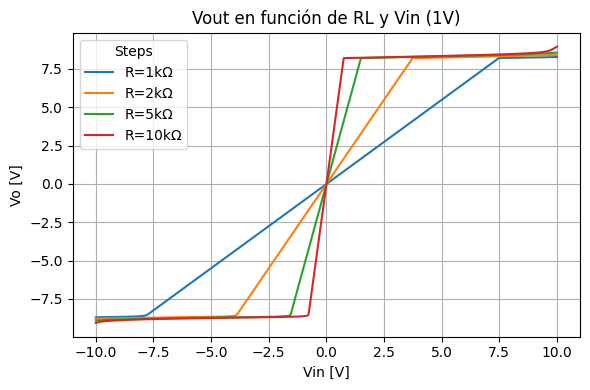

In [22]:
import re, math
import matplotlib.pyplot as plt

FILE_PATH = "Vout_Vin_1.txt"   # <-- nombre de tu archivo

# Conversión de sufijos (k, m, µ, etc.)
SI = {"k":1e3,"K":1e3,"m":1e-3,"u":1e-6,"µ":1e-6,"n":1e-9,"p":1e-12}
def parse_num(s):
    m = re.match(r'\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*([kKmMuUµnNpP]?)', s)
    return float(m.group(1)) * SI.get(m.group(2), 1.0) if m else float(s)

def fmt_rl(rl):
    return f"{rl/1e3:.0f}kΩ" if rl >= 1e3 else f"{rl:.0f}Ω"

blocks = []
cur = None
col_idx = None  # índices de columnas: {"vin": i, "vout": j}

with open(FILE_PATH, "r") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # Cabecera de columnas -> detectamos índices
        if line.lower().startswith("v3") or line.lower().startswith("v(v3)") \
           or (("v(vout)" in line.lower()) and ("step information" not in line.lower())):
            headers = line.split()
            name_to_i = {h.lower(): i for i, h in enumerate(headers)}
            # buscamos Vin (v3) y Vout
            i_vin  = name_to_i.get("v3", name_to_i.get("v(v3)", 0))
            i_vout = name_to_i.get("v(vout)")
            if i_vout is None:
                raise RuntimeError("No encontré columna V(vout) en el archivo.")
            col_idx = {"vin": i_vin, "vout": i_vout}
            continue

        # Nuevo step
        if line.lower().startswith("step information:"):
            if cur and cur["x"]:
                blocks.append(cur)
            info = line.split(":", 1)[1]
            m_rl = re.search(r'rl\s*=\s*([^\s,]+)', info, flags=re.I)
            RL = parse_num(m_rl.group(1)) if m_rl else math.nan
            cur = {"RL": RL, "x": [], "y": []}
            continue

        # Filas numéricas
        parts = line.split()
        if col_idx and len(parts) > max(col_idx.values()):
            try:
                vin  = float(parts[col_idx["vin"]])
                vout = float(parts[col_idx["vout"]])
                cur["x"].append(vin)
                cur["y"].append(vout)
            except ValueError:
                pass

# último bloque
if cur and cur["x"]:
    blocks.append(cur)

# --- Gráfico ---
plt.figure(figsize=(6,4))
for b in blocks:
    plt.plot(b["x"], b["y"], label=f"R={fmt_rl(b['RL'])}")

plt.xlabel("Vin [V]")
plt.ylabel("Vo [V]")
plt.title("Vout en función de RL y Vin (1V)")
plt.grid(True)
plt.legend(title="Steps")
plt.tight_layout()
plt.show()

## 2V

RL = 1kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.008084502), (-9.99, -0.008083524), (-9.98, -0.008082546)]
RL = 2kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.004256858), (-9.99, -0.004256296), (-9.98, -0.004255735)]
RL = 5kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.001769442), (-9.99, -0.00176912), (-9.98, -0.0017688)]
RL = 10kΩ  ->  primeros puntos (v3, IL): [(-10.0, -0.0009074329), (-9.99, -0.0009067921), (-9.98, -0.0009062119)]


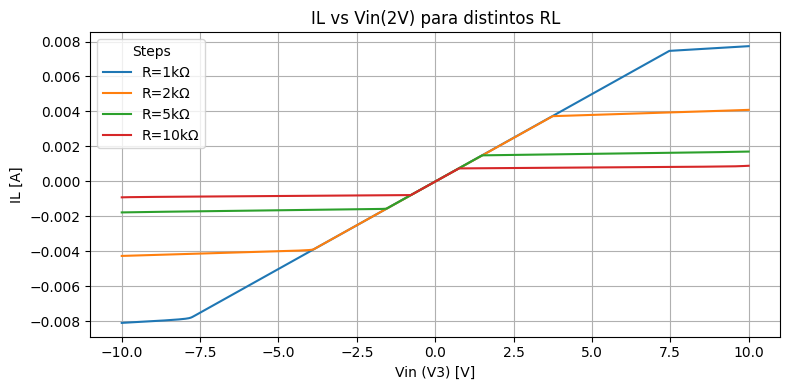

In [23]:
# --- IL vs v3 (LTspice .dc V3 ... con .step RL) ---
FILE_PATH = "IL_Vin_2.txt"   # <-- tu archivo exportado
FLIP_IL_SIGN = True

import re, math
import matplotlib.pyplot as plt

# Conversión de sufijos
SI = {"k":1e3,"K":1e3,"m":1e-3,"u":1e-6,"µ":1e-6,"n":1e-9,"p":1e-12}

def parse_num_with_suffix(s):
    m = re.match(r'\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*([kKmMuUµnNpP]?)', s)
    if not m:
        return float(s)
    return float(m.group(1)) * SI.get(m.group(2), 1.0)

def fmt_rl(rl):
    return f"{rl/1e3:.0f}kΩ" if rl>=1e3 else (f"{rl:.0f}Ω" if rl>=1 else f"{rl:g}Ω")

blocks = []
cur = None
col_idx = None  # dict con índices: {"v3":i, "il":j}

with open(FILE_PATH, "r") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # Cabecera de columnas: detectamos índices
        if line.lower().startswith(("v3","v(vin)","v(vout)","i(rl)")) and "step information" not in line.lower():
            headers = line.split()
            # mapa nombre -> índice
            name_to_idx = {h.lower(): i for i, h in enumerate(headers)}
            # buscamos índices relevantes
            i_v3 = name_to_idx.get("v3", 0)
            i_il = name_to_idx.get("i(rl)")
            if i_il is None:
                raise RuntimeError("No encontré la columna I(RL) en el archivo.")
            col_idx = {"v3": i_v3, "il": i_il}
            continue

        # Comienzo de un nuevo step
        if line.lower().startswith("step information:"):
            if cur and cur["x"]:
                blocks.append(cur)
            info = line.split(":",1)[1]
            m_rl = re.search(r'rl\s*=\s*([^\s,]+)', info, flags=re.I)
            RL = parse_num_with_suffix(m_rl.group(1)) if m_rl else math.nan
            cur = {"RL": RL, "x": [], "y": []}
            continue

        # Filas numéricas
        parts = line.split()
        if col_idx and len(parts) > max(col_idx.values()):
            try:
                x = float(parts[col_idx["v3"]])   # <<< eje X = V3 (la barrida)
                y = float(parts[col_idx["il"]])   # I(RL)
                if FLIP_IL_SIGN:
                    y = -y
                cur["x"].append(x)
                cur["y"].append(y)
            except ValueError:
                pass

# Agregar último bloque
if cur and cur["x"]:
    blocks.append(cur)

# Debug rápido: mostrar 3 puntos por step
for b in blocks:
    print(f"RL = {fmt_rl(b['RL'])}  ->  primeros puntos (v3, IL): {list(zip(b['x'][:3], b['y'][:3]))}")

# Plot
plt.figure(figsize=(8,4))
for b in blocks:
    plt.plot(b["x"], b["y"], label=f"R={fmt_rl(b['RL'])}")
plt.xlabel("Vin (V3) [V]")
plt.ylabel("IL [A]")
plt.title("IL vs Vin(2V) para distintos RL")
plt.grid(True)
plt.legend(title="Steps")
plt.tight_layout()
plt.show()

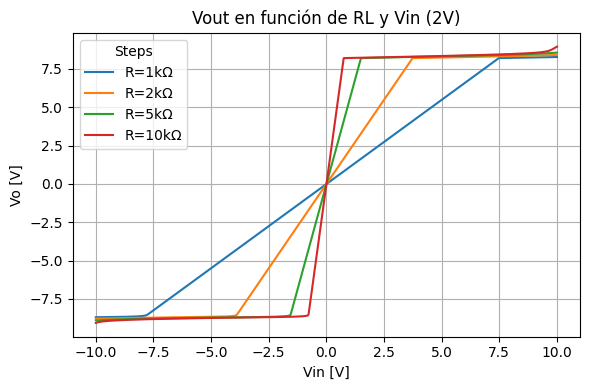

In [24]:
import re, math
import matplotlib.pyplot as plt

FILE_PATH = "Vout_Vin_2.txt"   # <-- nombre de tu archivo

# Conversión de sufijos (k, m, µ, etc.)
SI = {"k":1e3,"K":1e3,"m":1e-3,"u":1e-6,"µ":1e-6,"n":1e-9,"p":1e-12}
def parse_num(s):
    m = re.match(r'\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*([kKmMuUµnNpP]?)', s)
    return float(m.group(1)) * SI.get(m.group(2), 1.0) if m else float(s)

def fmt_rl(rl):
    return f"{rl/1e3:.0f}kΩ" if rl >= 1e3 else f"{rl:.0f}Ω"

blocks = []
cur = None
col_idx = None  # índices de columnas: {"vin": i, "vout": j}

with open(FILE_PATH, "r") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue

        # Cabecera de columnas -> detectamos índices
        if line.lower().startswith("v3") or line.lower().startswith("v(v3)") \
           or (("v(vout)" in line.lower()) and ("step information" not in line.lower())):
            headers = line.split()
            name_to_i = {h.lower(): i for i, h in enumerate(headers)}
            # buscamos Vin (v3) y Vout
            i_vin  = name_to_i.get("v3", name_to_i.get("v(v3)", 0))
            i_vout = name_to_i.get("v(vout)")
            if i_vout is None:
                raise RuntimeError("No encontré columna V(vout) en el archivo.")
            col_idx = {"vin": i_vin, "vout": i_vout}
            continue

        # Nuevo step
        if line.lower().startswith("step information:"):
            if cur and cur["x"]:
                blocks.append(cur)
            info = line.split(":", 1)[1]
            m_rl = re.search(r'rl\s*=\s*([^\s,]+)', info, flags=re.I)
            RL = parse_num(m_rl.group(1)) if m_rl else math.nan
            cur = {"RL": RL, "x": [], "y": []}
            continue

        # Filas numéricas
        parts = line.split()
        if col_idx and len(parts) > max(col_idx.values()):
            try:
                vin  = float(parts[col_idx["vin"]])
                vout = float(parts[col_idx["vout"]])
                cur["x"].append(vin)
                cur["y"].append(vout)
            except ValueError:
                pass

# último bloque
if cur and cur["x"]:
    blocks.append(cur)

# --- Gráfico ---
plt.figure(figsize=(6,4))
for b in blocks:
    plt.plot(b["x"], b["y"], label=f"R={fmt_rl(b['RL'])}")

plt.xlabel("Vin [V]")
plt.ylabel("Vo [V]")
plt.title("Vout en función de RL y Vin (2V)")
plt.grid(True)
plt.legend(title="Steps")
plt.tight_layout()
plt.show()